#Food-Nutrition Recognition using TensorFlow (CNN Model Inception V3)

We will build image recognition using CNN models (Inception V3), we’re utilizing TensorFlow for efficient data processing and Keras for the accurate recognition of image scans. TensorFlow provides powerful tools for handling and manipulating data, while Keras offers a user-friendly interface for building and training neural networks. Our dataset, sourced from Kaggle, encompasses a diverse range of images, including vegetables, fruits, and Indonesian food. This dataset enables us to train our models comprehensively and ensure robust performance across various food categories.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
#Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import warnings
import os
import cv2
import random
import csv
import glob
warnings.filterwarnings("ignore")
from sklearn import cluster
from PIL import Image
import tensorflow.keras.backend as be
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from sklearn import cluster
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
be.clear_session()

##Image Processing

Before we go to diving in our dataset, let's take one pics to understand the data

In [ ]:
img = plt.imread('/content/drive/MyDrive/Dataset Capstone/train/Anggur/Image_16.jpg')
dims = np.shape(img)
dims

In [ ]:
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

In [ ]:
plt.imshow(img)
print("Shape: ", dims[:2])
print('Color Channels: ', dims[2])
print('Min Color Depth: {}'.format(np.min(img)))
print('Max Color Depth: {}'.format(np.max(img)))

In [ ]:
sns.distplot(matrix[:,0], bins=20,color="purple",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="pink",hist_kws=dict(alpha=0.2))
plt.show()

This histogram provides an overview of the pixel value distribution and the contrast between these two color channels, allowing you to understand how color information is distributed within the image. By examining this histogram, you can explore the relationship between different color channels and gain deeper insights into the visual characteristics of the image you are analyzing.

In [ ]:
histogram = plt.hist2d(matrix[:,1] , matrix[:,2] , bins = (50,50))
plt.xlabel("Green Channel")
plt.ylabel("Blue Channel")
plt.show()

The pixels within the green and blue bands exhibit correlation, as indicated by their overlapping in the graph above, and usually result in discernible imagery. Adjustments such as scaling or thresholding may be necessary for raw band differences.







Image data encompasses variances arising from variations in scene resolutions, pixel intensities within an image, and the surrounding environment during image capture. This domain of image processing holds significant importance in the contemporary era, especially with the emergence of Artificial Intelligence. From motion detection to intricate systems in autonomous vehicles, research in this field demands extensive effort and represents rapidly expanding domains within computer vision.

In [ ]:
n_vals = [2, 4, 6, 8]
plt.figure(figsize=(12, 8))

for i, n in enumerate(n_vals):
    kmeans = cluster.KMeans(n_clusters=n)  # Modifikasi disini
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    plt.subplot(2, 2, i+1)
    plt.title("n = {}".format(n), pad=10, size=18)
    plt.imshow(clustered_img)

plt.tight_layout()
plt.show()

Well Done! Now, let's get to the next step

##Explanatory Data Analysis

In [ ]:
#path train
train_path = '/content/drive/MyDrive/Dataset Capstone/train'
data = dict()

for i in os.listdir(train_path):
  sub_dir = os.path.join(train_path, i)
  count = len(os.listdir(sub_dir))
  data[i] = count

labels = data.keys()
values = data.values()
colors = ["pink" if x <=150 else "purple" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
position_y = np.arange(len(values))
plt.barh(position_y, values, align='center', color=colors)
for i , v in enumerate(values):
    ax.text(v+1.4 , i-0.25 , str(v), color = colors[i])
ax.set_yticks(position_y)
ax.set_yticklabels(labels)
ax.set_xlabel('Images', fontsize=20)
plt.xticks(color='black', fontsize=13)
plt.yticks(fontsize=18)
plt.show()

We observe that there is a shortage of training data for the four classes (semangka, mangga, apel and anggur). It can be help with Data Augmentation by increasing the amount of relevant data in dataset.

In [ ]:
train_dir = "/content/drive/MyDrive/Dataset Capstone/train"
images = []

for food_dir in sorted(os.listdir(train_dir)):
  food_items = os.listdir(train_dir + "/" + food_dir)
  selected_food = np.random.choice(food_items)
  images.append(os.path.join(train_dir, food_dir,selected_food))

#visualize it
fig = plt.figure(1, figsize = (35,35))
for subplot, image_ in enumerate(images):
  category = image_ .split("/")[-2]
  imgs = plt.imread(image_)
  x,y,z = imgs.shape
  fig=plt.subplot(5,4,subplot+1)
  fig.set_title(category, pad =10, size=18)
  plt.imshow(imgs)

plt.tight_layout()

The code randomly selects one image from each food category in the training directory, then displays these images in subplots using matplotlib. This process provides a visual overview of the various food types present in the training dataset, facilitating an understanding of the variation and representation of each food category in the dataset.

##Training Model and Data Augmentation

In [ ]:
n_classes=8
batch_size = 32
img_width, img_height= 299, 299

path_train = '/content/drive/MyDrive/Dataset Capstone/train'
path_valid = '/content/drive/MyDrive/Dataset Capstone/valid'

#Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = val_datagen.flow_from_directory(
    path_valid,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

In [ ]:
mappin_class=train_generator.class_indices
mappin_class

##Training Model

In [ ]:
train_samples = len(train_generator)
valid_samples = len(valid_generator)


image_size = [299, 299]
inception = InceptionV3(input_shape = image_size + [3] , weights = "imagenet" , include_top = False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128 , activation = "relu")(x)
x = Dropout(0.2)(x)


In [ ]:
predictions = Dense(n_classes , kernel_regularizer = l2(0.005) , activation = "softmax")(x)

model = Model(inputs = inception.input , outputs = predictions)
model.compile(optimizer = SGD(learning_rate=0.0001 , momentum = 0.9) , loss = "categorical_crossentropy" , metrics = ["accuracy"])

In [ ]:
checkpoints = ModelCheckpoint(filepath = "cnn_model_capstone" , verbose = 1 , save_best_only = True)
csv_logger = CSVLogger("history_cnn_model_capstone.log")

In [ ]:
history = model.fit(
    train_generator,
    epochs=24,
    validation_data=valid_generator,
    verbose=1,
    callbacks=[csv_logger, checkpoints]
)

#ngl, i got 10 hours and half to train this model oml
#don't get away from colab

Epoch 1/24
41/41 [==============================] - ETA: 0s - loss: 2.0879 - accuracy: 0.2263 
Epoch 1: val_loss improved from inf to 1.79451, saving model to cnn_model_capstone
41/41 [==============================] - 1383s 33s/step - loss: 2.0879 - accuracy: 0.2263 - val_loss: 1.7945 - val_accuracy: 0.4295
Epoch 2/24
41/41 [==============================] - ETA: 0s - loss: 1.7711 - accuracy: 0.3899 
Epoch 2: val_loss improved from 1.79451 to 1.47777, saving model to cnn_model_capstone
41/41 [==============================] - 1294s 32s/step - loss: 1.7711 - accuracy: 0.3899 - val_loss: 1.4778 - val_accuracy: 0.5180
Epoch 3/24
41/41 [==============================] - ETA: 0s - loss: 1.5488 - accuracy: 0.5061 
Epoch 3: val_loss improved from 1.47777 to 1.22736, saving model to cnn_model_capstone
41/41 [==============================] - 1306s 32s/step - loss: 1.5488 - accuracy: 0.5061 - val_loss: 1.2274 - val_accuracy: 0.6984
Epoch 4/24
41/41 [==============================] - ETA: 0s - 

In [ ]:
model.save("model_inceptionV3.h5")

In [ ]:
def plot_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Accuracy_v1_InceptionV3.png')
    plt.show()

In [ ]:
def plot_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Loss_v1_InceptionV3.png')
    plt.show()

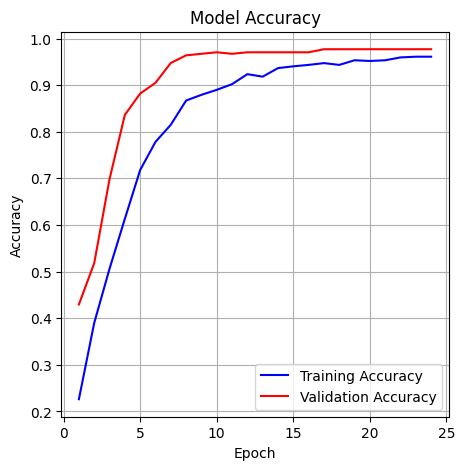

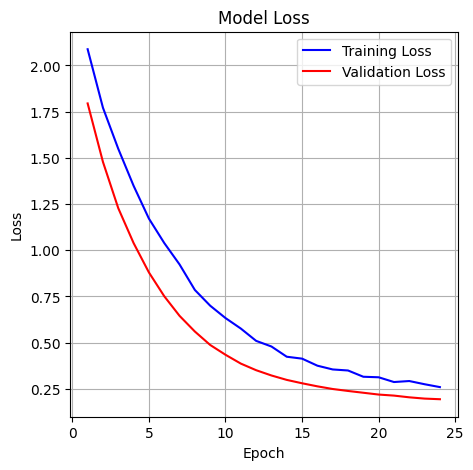

In [ ]:
plot_accuracy(history)
plot_loss(history)

## Saving Model to JSON Use TFJS

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
     

In [ ]:
saved_model_path = '/content/model_inceptionV3.h5'
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2024-06-07 02:09:30.215382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 02:09:31.958836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip inceptionV3_bin.zip *.bin

  adding: group1-shard10of22.bin (deflated 7%)
  adding: group1-shard11of22.bin (deflated 7%)
  adding: group1-shard12of22.bin (deflated 7%)
  adding: group1-shard13of22.bin (deflated 7%)
  adding: group1-shard14of22.bin (deflated 7%)
  adding: group1-shard15of22.bin (deflated 7%)
  adding: group1-shard16of22.bin (deflated 7%)
  adding: group1-shard17of22.bin (deflated 7%)
  adding: group1-shard18of22.bin (deflated 7%)
  adding: group1-shard19of22.bin (deflated 7%)
  adding: group1-shard1of22.bin (deflated 7%)
  adding: group1-shard20of22.bin (deflated 8%)
  adding: group1-shard21of22.bin (deflated 7%)
  adding: group1-shard22of22.bin (deflated 8%)
  adding: group1-shard2of22.bin (deflated 7%)
  adding: group1-shard3of22.bin (deflated 7%)
  adding: group1-shard4of22.bin (deflated 7%)
  adding: group1-shard5of22.bin (deflated 7%)
  adding: group1-shard6of22.bin (deflated 7%)
  adding: group1-shard7of22.bin (deflated 7%)
  adding: group1-shard8of22.bin (deflated 7%)
  adding: group1-shar

##Load The Model (.h5)

In [ ]:
be.clear_session()
model_path = "./model_inceptionV3.h5"
print("loading the model..")
model = load_model(model_path)
print("Done!")

loading the model..
Done!


##Testing Model

In [ ]:
img_width, img_height= 299, 299
batch_size=32

test_dir = '/content/drive/MyDrive/Dataset Capstone/test'
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (img_height , img_width),
                                                 batch_size = batch_size,
                                                 class_mode = "categorical")

Found 266 images belonging to 8 classes.


In [ ]:
scores = model.evaluate_generator(test_generator)
print("Test Accuracy : {:.3f}".format(scores[1]))

Test Accuracy : 0.974


In [ ]:
label_food= {'Anggur': 0,
 'Apel': 1,
 'Ayam Goreng': 2,
 'Mangga': 3,
 'Nasi Uduk': 4,
 'Semangka': 5,
 'Soto': 6,
 'Tempe Goreng': 7}

In [ ]:
category = {
    0: ['anggur', 'Anggur'],
    1: ['apel', 'Apel'],
    2: ['ayam_goreng', 'Ayam Goreng'],
    3: ['mangga', 'Mangga'],
    4: ['nasi_uduk', 'Nasi Uduk'],
    5: ['semangka', 'Semangka'],
    6: ['soto', 'Soto'],
    7: ['tempe_goreng', 'Tempe Goreng']
}

In [ ]:
def predict_image(filename , model):
    img_ = image.load_img(filename , target_size = (299,299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array , axis = 0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)

    predicted_label = category[index][1]

    with open("/content/Nutrisi - Sheet1.csv") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row["Label"] == predicted_label:
                print("Food Name: ", row['Label'])
                print("Vitamin: ", row["Vitamin"])
                print("Carbohydrates: ", row["Karbohidrat"])
                print("Lemak: ", row["Lemak"])
                print("Protein: ", row["Protein"])
                break


## Error Analysis
We can try to understand on which kind of images the classifier has trouble.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

img_width, img_height = 299, 299

def labels_confusion_matrix():
    folder_path="/content/drive/MyDrive/Dataset Capstone/test"

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

In [ ]:
def print_confusion_matrix(real,predicted):
    cmap="viridis"
    cm_plot_labels = [i for i in range(8)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1)
    plt.figure(figsize = (10,10))
    s=sns.heatmap(df_cm, annot=True,cmap=cmap)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
y_true,y_pred=labels_confusion_matrix()
print_confusion_matrix(y_true,y_pred)

1/1 [==============================] - 1s 673ms/step


In [ ]:
cf_matrix = confusion_matrix(true_labels, predicted_classes, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, fmt='.2f', xticklabels = sorted(set(class_names)), yticklabels = sorted(set(class_names)))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

## Wrong Prediction
Let's see where the model has given wrong predictions and what were the actual predictions on those images.


In [ ]:
errors = (true_labels - predicted_classes != 0)
y_true_errors = true_labels[errors]
y_pred_errors = predicted_classes[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [ ]:
labels = {value: key for key, value in test_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dir, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions Made on Test Set', fontsize=20)
plt.show()